# Characterizing Photorealism and Artifacts in Diffusion Model-Generated Images
## Author: Negar Kamali

In [2]:
pip install rpy2==3.5.17 

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for rpy2: filename=rpy2-3.5.17-cp312-cp312-macosx_11_0_arm64.whl size=252670 sha256=f7c3ff2b12ac75f537187ead9df795411846ef647179b16cbdbedc8f0db9e5b1
  Stored in directory: /Users/negarkamali/Library/Caches/pip/wheels/fb/3c/a8/5c2ab28ca010aa26f09174d6ac337141721ee764f7b17c0953
Successfully built rpy2
  Attempting uninstall: rpy2
    Found existing installation: rpy2 3.5.16
    Uninstalling rpy2-3.5.16:
      Successfully uninstalled rpy2-3.5.16
Note: you may need to restart the kernel to use updated packages.


In [3]:
%load_ext rpy2.ipython

In [4]:
%%R
options(warn = -1)

In [5]:
%%R
if (!requireNamespace("ggplot2", quietly = TRUE)) install.packages("ggplot2", version = "3.4.5")
if (!requireNamespace("binom", quietly = TRUE)) install.packages("binom", version = "1.1-1.1")
if (!requireNamespace("ggbeeswarm", quietly = TRUE)) install.packages("ggbeeswarm", version = "0.7.2")
if (!requireNamespace("dplyr", quietly = TRUE)) install.packages("dplyr", version = "1.1.4")
if (!requireNamespace("tidybayes", quietly = TRUE)) install.packages("tidybayes", version = "3.0.7")
if (!requireNamespace("boot", quietly = TRUE)) install.packages("boot", version = "1.3-31")
if (!requireNamespace("patchwork", quietly = TRUE)) install.packages("patchwork", version = "1.3.0")
if (!requireNamespace("ggdist", quietly = TRUE)) install.packages("ggdist", version = "3.3.2")
if (!requireNamespace("zoo", quietly = TRUE)) install.packages("zoo", version = "1.8-12")
if (!requireNamespace("purrr", quietly = TRUE)) install.packages("purrr", version = "1.0.2")
if (!requireNamespace("signal", quietly = TRUE)) install.packages("signal", version = "1.8-1")
if (!requireNamespace("stringr", quietly = TRUE)) install.packages("stringr", version = "1.5.1")
if (!requireNamespace("readr", quietly = TRUE)) install.packages("readr", version = "2.1.5")
if (!requireNamespace("tidyr", quietly = TRUE)) install.packages("tidyr", version = "1.3.1")
if (!requireNamespace("testthat", quietly = TRUE)) install.packages("testthat", version = "3.2.3")

In [6]:
%%R
suppressMessages({
    library(ggplot2)
    library(binom)
    library(ggbeeswarm)
    library(dplyr)
    library(tidybayes)
    library(boot)
    library(patchwork)
    library(ggdist)
    library(purrr)
    library(stringr)
    library(readr)
    library(tidyr)
    library(testthat)
})

In [7]:
%%R
df_imagemap <- read.csv('data/image_metadata.csv', sep = ",")
df_user_guesses <- read.csv('data/data.csv', colClasses = c(video = "character"), sep = ",")
df_value_added <- read.csv("data/human_curation.csv", sep = ",")
data_annotations <- read.csv("data/artifact_annotations.csv", stringsAsFactors = FALSE, sep = ",")
df_comments <- read.csv("data/classified_comments_chunked.csv", sep = ",")

In [8]:
%%R
# print number of rows of dataframes
print(paste("Number of rows in df_imagemap:",nrow(df_imagemap)))
print(paste("Number of rows in df_user_guesses:", nrow(df_user_guesses)))
print(paste("Number of rows in df_value_added:", nrow(df_value_added)))
print(paste("Number of rows in data_annotations:", nrow(data_annotations)))
print(paste("Number of rows in df_comments:", nrow(df_comments)))

# number of unique user_ids ins df_user_guesses
print(paste("Number of unique user_ids in df_user_guesses:", length(unique(df_user_guesses$user_id))))

# number of fake and real images in df_imagemap
print(paste("Number of fake images in df_imagemap:", sum(df_imagemap$fake == 1)))
print(paste("Number of real images in df_imagemap:", sum(df_imagemap$fake == 0)))


[1] "Number of rows in df_imagemap: 1088"
[1] "Number of rows in df_user_guesses: 749828"
[1] "Number of rows in df_value_added: 39"
[1] "Number of rows in data_annotations: 340"
[1] "Number of rows in df_comments: 34674"
[1] "Number of unique user_ids in df_user_guesses: 50444"
[1] "Number of fake images in df_imagemap: 938"
[1] "Number of real images in df_imagemap: 150"


### Data Preparation

In [10]:
%%R

# This code processes and analyzes image classification data:

# 1. Creates a mapping of old filenames to new filenames from df_imagemap

# 2. Updates the user guesses dataset (df_user_guesses) by:
# - Mapping old filenames to new ones
# - Joining with image metadata
# - Adding category labels based on filename prefixes (ff_, mj_, sd_, etc)
# - Filtering out pre-watched entries

# 3. Filters out users who saw "Permutations" images

# 4. Adds columns for:
# - fake (0/1)
# - guess_fake (0/1) 
# - is_correct (whether guess matches reality)

# 5. Calculates accuracy statistics per image:
# - Groups by filename
# - Computes mean accuracy and number of observations
# - Adds categorization columns:
#   - fake_or_real (Firefly/MidJourney/etc)
#   - subcategory (Portrait/Full Body/etc)
#   - subsubcategory (celebrity/culture/etc)
# - Adds filename and URL link

# 6. Saves results to CSV file 'image_accuracy_links.csv'

# Original code follows:

# Map filenames from df_imagemap
filename_mapping <- setNames(df_imagemap$filename, df_imagemap$filename_old)

test_that("filename_mapping is correct", {
  expect_equal(length(filename_mapping), nrow(df_imagemap))
  expect_equal(names(filename_mapping), df_imagemap$filename_old)
  expect_equal(filename_mapping, setNames(df_imagemap$filename, df_imagemap$filename_old))
})

# Update 'video' column in df_user_guesses with mapped filenames
df_user_guesses_mapped <- df_user_guesses %>%
  mutate(video = ifelse(video %in% names(filename_mapping), filename_mapping[video], video))

test_that("df_user_guesses_mapped is correct", {
  expect_equal(length(df_user_guesses_mapped$video), nrow(df_user_guesses))
})

# Merge df_user_guesses with df_imagemap
merged_df <- df_user_guesses_mapped %>%
  left_join(
    df_imagemap %>% select(filename, filename_old, fake),
    by = c("video" = "filename")
  ) %>%
  # Add filename and category columns
  mutate(
    filename = ifelse(filename_old %in% names(filename_mapping), filename_mapping[filename_old], NA),
    category = case_when(
      grepl("^ff_", filename_old) ~ "Firefly",
      grepl("^mj_", filename_old) ~ "MidJourney",
      grepl("^sd_", filename_old) ~ "Stable Diffusion",
      grepl("^uk_", filename_old) ~ "Unknown",
      grepl("^Perm", filename_old) ~ "Permutations",
      TRUE ~ "Reals"
    )
  ) %>%
  drop_na(filename) %>%  # Ensure 'filename' column exists and drop NA rows
  filter(pre_watched != "1")  # Exclude pre-watched rows

test_that("merged_df has correct structure and content", {
  # Test structure
  expect_true(is.data.frame(merged_df))
  expect_true(all(colnames(df_user_guesses_mapped) %in% colnames(merged_df)))
  expect_true(all(colnames(df_imagemap) %in% colnames(merged_df)))
  expect_true('category' %in% colnames(merged_df))

  # Test data types
  expect_true(is.character(merged_df$category))
  expect_true(is.character(merged_df$filename))
  expect_true(is.integer(merged_df$fake))
  expect_true(is.integer(merged_df$guess_fake))
  
  # Test value constraints
  expect_true(all(merged_df$fake %in% c(0,1)))
  expect_true(all(merged_df$guess_fake %in% c(0,1)))
  
  # Test category values
  expect_true(all(merged_df$category %in% c("Firefly", "MidJourney", "Stable Diffusion", "Unknown", "Permutations", "Reals")))
  
  # Test that no pre-watched entries exist
  expect_equal(sum(merged_df$pre_watched == "1", na.rm = TRUE), 0)
  
  # Test that all filenames are mapped (no NAs)
  expect_true(!any(is.na(merged_df$filename)))
})


# Filter out users with "Permutations" in 'filename_old'
users_with_permutations <- merged_df %>%
  filter(filename_old == "Permutations") %>%
  pull(user_id) %>%
  unique()

merged_df <- merged_df %>%
  filter(!user_id %in% users_with_permutations) %>%
  mutate(
    fake = as.integer(fake),
    guess_fake = as.integer(guess_fake),
    is_correct = as.integer(fake == guess_fake)
  )

  test_that("merged_df has correct structure and content", {
    expect_true(is.data.frame(merged_df))
    expect_true(all(!merged_df$user_id %in% users_with_permutations))
    expect_true(all(merged_df$fake %in% c(0,1)))
    expect_true(all(merged_df$guess_fake %in% c(0,1)))
    expect_true(all(merged_df$is_correct %in% c(0,1)))

    category_counts <- merged_df %>%
      group_by(category) %>%
      summarise(n = n_distinct(filename))
    
    # check that the number of unique filenames for each category is correct
    expect_equal(category_counts$n[category_counts$category == "Firefly"], 133)
    expect_equal(category_counts$n[category_counts$category == "MidJourney"], 207)
    expect_equal(category_counts$n[category_counts$category == "Stable Diffusion"], 110)
    expect_equal(category_counts$n[category_counts$category == "Reals"], 150)
    expect_equal(category_counts$n[category_counts$category == "Unknown"], 5)
  })

# Calculate accuracy
df_image_accuracy <- merged_df %>%
  group_by(filename_old) %>%
  summarise(
    accuracy = mean(is_correct, na.rm = TRUE),  # Ensure no issues with NA
    observations = n()
  ) %>%
  filter(filename_old != '.DS_Store') %>%
  mutate(
    fake_or_real = case_when(
      grepl("^ff_", filename_old) ~ "Firefly",
      grepl("^mj_", filename_old) ~ "MidJourney",
      grepl("^sd_", filename_old) ~ "Stable Diffusion",
      grepl("^uk_", filename_old) ~ "Unknown",
      TRUE ~ "Reals"
    ),
    subcategory = case_when(
      grepl("portrait", filename_old) ~ "Portrait",
      grepl("fullbody", filename_old) ~ "Full Body",
      grepl("pg", filename_old) ~ "Posed Group",
      grepl("ng", filename_old) ~ "Naturalistic Group",
      TRUE ~ "Unknown"
    ),
    subsubcategory = case_when(
      grepl("_1[^0-9]", filename_old) ~ "celebrity",
      grepl("_2[^0-9]", filename_old) ~ "culture",
      grepl("_3[^0-9]", filename_old) ~ "generic",
      grepl("_4[^0-9]", filename_old) ~ "rare",
      TRUE ~ "Unknown"
    ),
    filename = filename_mapping[filename_old],
    link = paste0("https://detectfakes.kellogg.northwestern.edu/static/image_stimuli/", filename)
  ) %>%
  select(
    filename, filename_old, accuracy, observations, fake_or_real,
    subcategory, subsubcategory, link
  )

  test_that("df_image_accuracy has correct structure and content", {
    expect_true(is.data.frame(df_image_accuracy))
    cols = c("filename", "filename_old", "accuracy", "observations", "fake_or_real", "subcategory", "subsubcategory", "link")
    expect_true(all(cols %in% colnames(df_image_accuracy)))
    # check number of reals
    expect_equal(nrow(df_image_accuracy %>% filter(fake_or_real == "Firefly")), 133)
    expect_equal(nrow(df_image_accuracy %>% filter(fake_or_real == "MidJourney")), 207)
    expect_equal(nrow(df_image_accuracy %>% filter(fake_or_real == "Stable Diffusion")), 110)
    expect_equal(nrow(df_image_accuracy %>% filter(fake_or_real == "Unknown")), 5)
    expect_equal(nrow(df_image_accuracy %>% filter(fake_or_real == "Reals")), 149)
  })

# Save to CSV
write.csv(df_image_accuracy, 'image_accuracy_links.csv', row.names = FALSE)

Test passed 🥇
Test passed 🎉
Test passed 🥳
Test passed 🎊
Test passed 🌈


In [11]:
%%R
print(paste("Number of rows in df_image_accuracy:", nrow(df_image_accuracy)))
print(paste("Number of unique users in merged_df:", length(unique(merged_df$user_id))))
print(paste("Number of rows in merged_df:", nrow(merged_df)))
print(paste("Number of comments in merged_df:", length(unique(merged_df$participant_comment))))

[1] "Number of rows in df_image_accuracy: 604"
[1] "Number of unique users in merged_df: 37581"
[1] "Number of rows in merged_df: 541283"
[1] "Number of comments in merged_df: 27139"


In [12]:
%%R
# group by fake_or_real and count number of rows
df_image_accuracy %>%
  group_by(fake_or_real) %>%
  summarise(n = n())


# A tibble: 5 × 2
  fake_or_real         n
  <chr>            <int>
1 Firefly            133
2 MidJourney         207
3 Reals              149
4 Stable Diffusion   110
5 Unknown              5


In [13]:
%%R
# group by subcategory and count number of rows
df_image_accuracy %>%
  group_by(subcategory) %>%
  summarise(n = n())

# A tibble: 4 × 2
  subcategory            n
  <chr>              <int>
1 Full Body            124
2 Naturalistic Group   118
3 Portrait             228
4 Posed Group          134


In [14]:
%%R
head(df_image_accuracy)

# A tibble: 6 × 8
  filename           filename_old accuracy observations fake_or_real subcategory
  <chr>              <chr>           <dbl>        <int> <chr>        <chr>      
1 afa29754521b85a7b… ff_fullbody…    0.864         1104 Firefly      Full Body  
2 fdced9599f3452053… ff_fullbody…    0.871         1257 Firefly      Full Body  
3 a062b83843cb1870e… ff_fullbody…    0.870         1154 Firefly      Full Body  
4 e2ded59d99ef59549… ff_fullbody…    0.883         1338 Firefly      Full Body  
5 6524e92d34c9d8099… ff_fullbody…    0.947         1351 Firefly      Full Body  
6 38cfc344d737b8666… ff_fullbody…    0.891         1250 Firefly      Full Body  
# ℹ 2 more variables: subsubcategory <chr>, link <chr>


In [15]:
%%R
head(merged_df)

  id                          user_id assignment
1 22 de7431f15eb29f1c845e569e32a0ea3a  unlimited
2 23 de7431f15eb29f1c845e569e32a0ea3a  unlimited
3 24 20b402643a5dec26795580a9b9f8bd70  unlimited
4 26 20b402643a5dec26795580a9b9f8bd70  unlimited
5 31 ef7ce0d39dc9d67138965ceec5e51426  unlimited
6 32 ef7ce0d39dc9d67138965ceec5e51426  unlimited
                                                                  video
1 bc2aa38a0c2b0b8990392684259bcfe08533ee9b25348213d9ac356d4eadcf75.jpeg
2 501f1f9992f910d097c56b82b13e55b00bae418e7c527a1764f2acfd283f39d4.jpeg
3 d454db94cd3be23bb967c78dceb8a045d7e4023231f233cd79d66e830ce40ddf.jpeg
4 77e831c12f1b6ab7cb36524f8e5b6a9dba54ba67a7b6d83ee3cc5654dd7fa564.jpeg
5 35bdc7578de33e60547e7c87cb903275aed53c3119ae9bf034f455f8c171b6ce.jpeg
6 35bdc7578de33e60547e7c87cb903275aed53c3119ae9bf034f455f8c171b6ce.jpeg
  guess_fake guess_real              guess guess_int seen pre_watched
1          1          0 Somewhat confident         3    0           0
2          0 

### 5.1 Overall Accuracy

In [17]:
%%R

# Calculate overall accuracy statistics
# Get mean accuracy and confidence intervals using bootstrapping
# Group data by image type (Fake vs Real) and summarize results
# Print formatted output showing mean accuracy and 95% CI for each type


# Bootstrap function
boot_mean <- function(data, indices) {
 mean(data[indices])
}
df_image_accuracy$image_type <- factor(ifelse(df_image_accuracy$fake_or_real == "Reals", "Real", "Fake"), levels = c("Fake", "Real"))

# Get CIs by image type
accuracy_stats <- df_image_accuracy %>%
 group_by(image_type) %>%
 summarize(
   mean_acc = mean(accuracy),
   ci = list(boot(accuracy, boot_mean, R=1000) %>% 
             boot.ci(type="perc") %>% 
             {c(.$percent[4], .$percent[5])})
 ) %>%
 mutate(
   ci_lower = sapply(ci, `[`, 1),
   ci_upper = sapply(ci, `[`, 2)
 )

cat(sprintf("Mean accuracy for AI-generated images: %.0f%% (95%% CI:[%.0f,%.0f])\n", 
           accuracy_stats$mean_acc[accuracy_stats$image_type == "Fake"] * 100,
           accuracy_stats$ci_lower[accuracy_stats$image_type == "Fake"] * 100,
           accuracy_stats$ci_upper[accuracy_stats$image_type == "Fake"] * 100))

cat(sprintf("Mean accuracy for real images: %.0f%% (95%% CI:[%.0f,%.0f])", 
           accuracy_stats$mean_acc[accuracy_stats$image_type == "Real"] * 100,
           accuracy_stats$ci_lower[accuracy_stats$image_type == "Real"] * 100,
           accuracy_stats$ci_upper[accuracy_stats$image_type == "Real"] * 100))

Mean accuracy for AI-generated images: 76% (95% CI:[75,77])
Mean accuracy for real images: 74% (95% CI:[72,76])

#### Figure 7

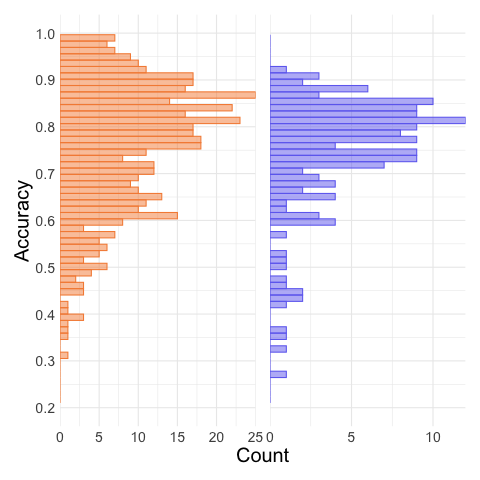

In [19]:
%%R

# Create a histogram showing the distribution of accuracy scores for fake and real images
# The histograms are displayed side by side, with fake images on the left and real on the right
# The x-axis shows the count of responses at each accuracy level
# The y-axis shows the accuracy from 0.2 to 1.0
# Uses custom colors: orange (#F58C42) for fake images and blue (#6F6FF0) for real images
# Includes minimal theme styling and removes legend


max_count <- max(tapply(df_image_accuracy$accuracy, df_image_accuracy$image_type, function(x) sum(!is.na(x))))


breaks_x <- seq(0, max_count, by = ceiling(max_count / 100))  # Adjust the divisor (5) to change the number of ticks

p2 <- ggplot(df_image_accuracy, aes(y = accuracy, fill = image_type)) +
  geom_histogram(aes(x = after_stat(count), color = image_type), 
                 position = "identity", 
                 bins = 60, 
                 alpha = 0.5,  
                 size = 0.5) +   
scale_fill_manual(values = c("Fake" = "#F58C42", "Real" = "#6F6FF0")) +
    scale_color_manual(values = c("Fake" = "#F58C42", "Real" = "#6F6FF0"), guide = FALSE) +
    scale_y_continuous(limits = c(0.2, 1), breaks = seq(0, 1, 0.1)) +
    scale_x_continuous(expand = c(0, 0), breaks = breaks_x) +  # Set the breaks here
    labs(y = "Accuracy", x = "Count") +
    theme_minimal() +
    theme(legend.position = "none",
          axis.text = element_text(size = 14),
          axis.title = element_text(size = 20),
          plot.margin = unit(c(1, 1, 1, 1), "lines"),
          panel.spacing = unit(1, "lines"),
          strip.background = element_blank(),
          strip.text.x = element_blank()) +
    facet_wrap(~ image_type, ncol = 2, scales = "free_x")  # Keep scales = "free_x" for horizontal histograms

print(p2)
ggsave("accuracy_horizontal_histograms_side_by_side.png", p2, width = 6, height = 8, dpi = 300)


### 5.2 Participant Level Accuracy
#### Figure 9

Test passed 🎊
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


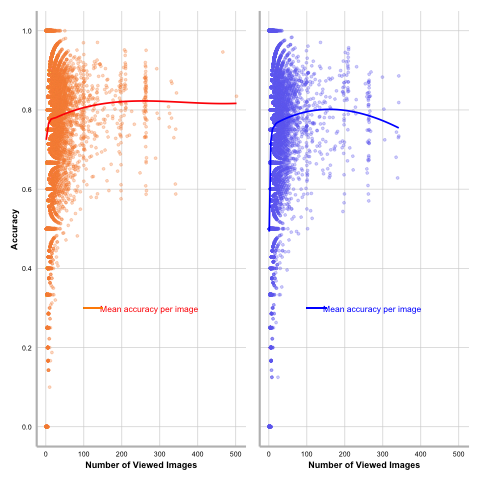

In [21]:
%%R

# Calculate accuracy statistics for each participant viewing fake and real images
# Create scatter plots showing:
# - Each point represents one participant's accuracy score
# - X-axis shows number of images viewed by that participant
# - Y-axis shows raw accuracy (proportion correct)
# - Orange line shows mean accuracy trend
# - Red line shows smoothed accuracy trend using LOESS
# Plots are separated for fake vs real image viewing


# Step 1: Add fake_or_real column to merged_df
merged_df <- merged_df %>%
  mutate(fake_or_real = ifelse(category %in% c("Real", "Reals"), "Real", "Fake"))

# Step 2: Calculate image difficulty
image_difficulty <- merged_df %>%
  group_by(filename) %>%
  summarize(
    difficulty = 1 - mean(is_correct),
    n_views = n()
  )

# Step 3: Merge difficulty scores with original data
merged_df_with_difficulty <- merged_df %>%
  left_join(image_difficulty, by = "filename")

# test that merged_df_with_difficulty has the correct structure and content
test_that("merged_df_with_difficulty has correct structure and content", {
  expect_true(is.data.frame(merged_df_with_difficulty))
  expect_true(all(c("user_id", "filename", "fake_or_real", "difficulty", "n_views") %in% colnames(merged_df_with_difficulty)))
})

# Step 4: Calculate adjusted accuracy for each user
user_accuracy <- merged_df_with_difficulty %>%
  group_by(user_id) %>%
  summarize(
    raw_accuracy = mean(is_correct),
    adjusted_accuracy = mean(is_correct / (1 - difficulty)),
    n_images = n(),
    fake_or_real = first(fake_or_real)
  )
x_limits <- range(c(dplyr::filter(user_accuracy, fake_or_real == "Fake")$n_images,
                    dplyr::filter(user_accuracy, fake_or_real == "Real")$n_images))
y_limits <- range(c(dplyr::filter(user_accuracy, fake_or_real == "Fake")$raw_accuracy,
                    dplyr::filter(user_accuracy, fake_or_real == "Real")$raw_accuracy))
line_length <- diff(x_limits) * 0.1

scatter_plot_fake <- ggplot(dplyr::filter(user_accuracy, fake_or_real == "Fake"), 
                             aes(x = n_images, y = raw_accuracy, color = "AI-generated")) +
  geom_point(size = 1, alpha = 0.3) +  
  geom_smooth(method = "loess", se = FALSE, color = "red", size = 0.8, linetype = "solid") +
  annotate("text", x = max(x_limits) * 0.8, y = max(y_limits) * 0.3, 
           label = "Mean accuracy per image", color = "red", size = 3, hjust = 1) +
 geom_segment(aes(x = max(x_limits) * 0.2, 
                   xend = max(x_limits) * 0.2 + line_length, 
                   y = max(y_limits) * 0.3, 
                   yend = max(y_limits) * 0.3), 
               color = "darkorange", size = 0.8) +  # Add orange line
  scale_x_continuous(limits = x_limits, breaks = seq(0, max(x_limits), by = 100)) +  
  scale_y_continuous(limits = y_limits, breaks = seq(0, 1, by = 0.2)) +  
  labs(x = "Number of Viewed Images", y = "Accuracy") +
  theme_minimal() +
  theme(
    axis.title.x = element_text(size = 9, color = "black", face = "bold"),
    axis.title.y = element_text(size = 9, color = "black", face = "bold"),
    axis.text.x = element_text(size = 7, color = "black"),
    axis.text.y = element_text(size = 7, color = "black"),
    axis.line.y = element_line(color = "gray", size = 1),
    axis.line.x = element_line(color = "gray", size = 1),
    panel.grid.major = element_line(color = "lightgray", size = 0.3),  
    panel.grid.minor = element_blank(),  
    legend.position = c(0.5, 1.05),  
    legend.justification = "center",
    legend.margin = margin(0, 0, -5, 0),  
    legend.text = element_text(size = 9, color = "black", face = "bold")  
  ) +
  scale_color_manual(values = c("AI-generated" = "#F58C42"))


scatter_plot_real <- ggplot(dplyr::filter(user_accuracy, fake_or_real == "Real"), 
                             aes(x = n_images, y = raw_accuracy, color = "Real")) +
  geom_point(size = 1, alpha = 0.3) +  
  geom_smooth(method = "loess", se = FALSE, color = "blue", size = 0.8, linetype = "solid") +
  annotate("text", x = max(x_limits) * 0.8, y = max(y_limits) * 0.3, 
           label = "Mean accuracy per image", color = "blue", size = 3, hjust = 1) +
 geom_segment(aes(x = max(x_limits) * 0.2, 
                   xend = max(x_limits) * 0.2 + line_length, 
                   y = max(y_limits) * 0.3, 
                   yend = max(y_limits) * 0.3), 
               color = "blue", size = 0.8) +  # Add orange line
  scale_x_continuous(limits = x_limits, breaks = seq(0, max(x_limits), by = 100)) +  
  scale_y_continuous(limits = y_limits, breaks = seq(0, 1, by = 0.2)) +  
  labs(x = "Number of Viewed Images", y = "Accuracy") +
  theme_minimal() +
  theme(
    axis.title.x = element_text(size = 9, color = "black", face = "bold"),
    axis.title.y = element_blank(),  
    axis.text.x = element_text(size = 7, color = "black"),
    axis.text.y = element_blank(),  
    axis.line.y = element_line(color = "gray", size = 1),
    axis.line.x = element_line(color = "gray", size = 1),
    panel.grid.major = element_line(color = "lightgray", size = 0.3),  
    panel.grid.minor = element_blank(),  
    legend.position = c(0.5, 1.05),  
    legend.justification = "center",
    legend.margin = margin(0, 0, -5, 0),  
    legend.text = element_text(size = 9, color = "black", face = "bold")  
  ) +
  scale_color_manual(values = c("Real" = "#6F6FF0"))

combined_scatter_plot <- scatter_plot_fake + scatter_plot_real + 
  plot_layout(ncol = 2) & 
  theme(legend.title = element_blank())
print(combined_scatter_plot)
ggsave("combined_scatter_plot_accuracy_images_with_legend_top.png", combined_scatter_plot, width = 7.5, height = 2.8, dpi = 300)


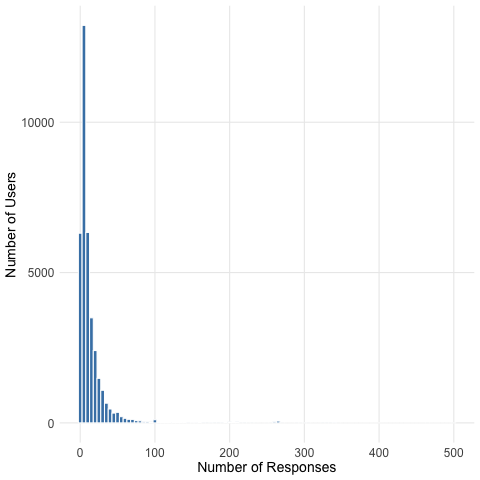

In [23]:
%%R

# These 2 cell creates two plots:
# 1. A histogram showing the distribution of total responses per user
# 2. A histogram showing the accuracy distribution for users who completed at least 10 responses
#    (using only their first 10 responses to control for learning effects)
# 
# For the first plot:
# - Groups data by user_id to count total responses per user
# - Creates histogram with 5-response bins
# - Uses steelblue fill with white borders
# - Applies minimal theme with customized text sizes
#
# For the second plot:
# - Filters for users with 10+ responses and uses only first 10 responses
# - Shows accuracy distribution with 0.05-width bins
# - Adds red dashed line at mean accuracy
# - Uses bold axis titles and thicker axis lines
# - Removes minor gridlines


response_counts <- merged_df %>%
  group_by(user_id) %>%
  summarise(total_responses = n())


response_dist_plot <- ggplot(response_counts, aes(x = total_responses)) +
  geom_histogram(binwidth = 5, fill = "steelblue", color = "white") +
  labs(x = "Number of Responses", y = "Number of Users") +
  theme_minimal() +
  theme(
    axis.title = element_text(size = 14),
    axis.text = element_text(size = 12),
    panel.grid.minor = element_blank(),
    legend.text = element_text(size = 14),
    legend.title = element_text(size = 14),
    legend.position = "none"  # No legend needed here
  )


ggsave("response_distribution.png", response_dist_plot, width = 8, height = 6, dpi = 300)
print(response_dist_plot)


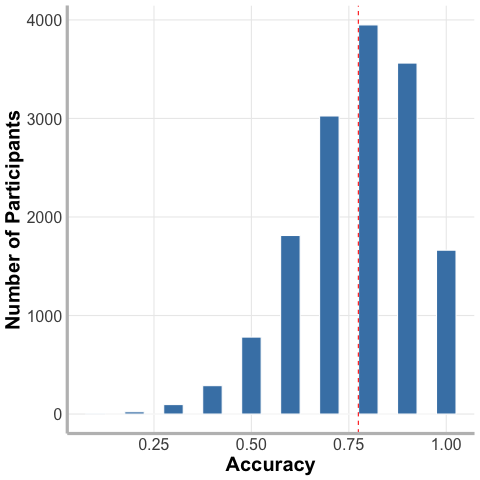

In [24]:
%%R

controlled_accuracy <- merged_df %>%
  group_by(user_id) %>%
  mutate(total_responses = n()) %>%
  dplyr::filter(total_responses >= 10) %>%
  mutate(attempt_number = row_number()) %>%
  dplyr::filter(attempt_number <= 10) %>%
  summarise(
    accuracy = mean(is_correct),
    n_responses = n()
  ) %>%
  ungroup()


accuracy_dist_plot <- ggplot(controlled_accuracy, aes(x = accuracy)) +
  geom_histogram(binwidth = 0.05, fill = "steelblue", color = "white") +
  geom_vline(xintercept = mean(controlled_accuracy$accuracy), 
             color = "red", linetype = "dashed") +
  labs(x = "Accuracy", y = "Number of Participants") +
  theme_minimal() +
  theme(
    axis.title = element_text(size = 20,face = "bold"),
    axis.text = element_text(size = 16),
    axis.line.y = element_line(color = "gray", linewidth = 1.5),
    axis.line.x = element_line(color = "gray", linewidth = 1.5),
    panel.grid.minor = element_blank(),
    legend.text = element_text(size = 14),
    legend.title = element_text(size = 14),
    legend.position = "none"  # No legend needed here
  )


ggsave("accuracy_distribution.png", accuracy_dist_plot, width = 8, height = 6, dpi = 300)
print(accuracy_dist_plot)

[1] "Total number of users who saw 10+ images: 15203"
Test passed 😀
Test passed 😸
Test passed 🌈
Test passed 😀
Test passed 😸
Test passed 🥇
[1] "Proportion of images identified as fake and real for each attempt:"
# A tibble: 10 × 6
   attempt_number total_fake_chosen total_real_chosen total_attempts
            <int>             <int>             <int>          <int>
 1              1              9494              5709          15203
 2              2              8194              7009          15203
 3              3              8320              6883          15203
 4              4              8078              7125          15203
 5              5              8033              7170          15203
 6              6              7969              7234          15203
 7              7              7932              7271          15203
 8              8              7879              7324          15203
 9              9              7739              7464          15203
10         

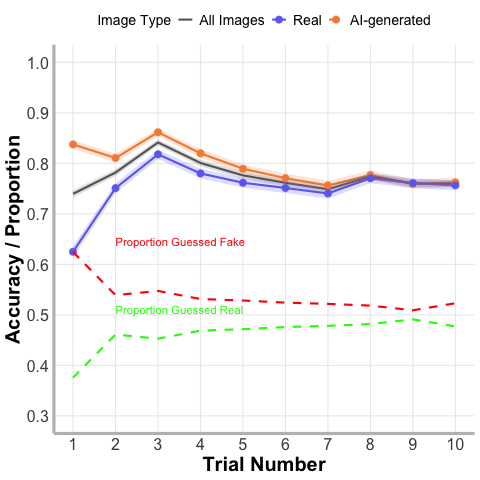

In [26]:
%%R

# This cell calculates accuracy statistics for participants who completed at least 10 trials
# First it filters for users with 10+ responses and takes their first 10 attempts
# Then calculates:
# 1. Proportion of images labeled as fake vs real for each attempt number
# 2. Learning curve with confidence intervals showing accuracy over attempts
# 3. Overall accuracy statistics across all attempts


# Calculate the proportion of images participants identified as fake and real for each attempt
# 1. First identify users who saw at least 10 images
users_10plus <- merged_df %>%
  group_by(user_id) %>%
  summarise(total_images = n()) %>%
  dplyr::filter(total_images >= 10)

print(paste("Total number of users who saw 10+ images:", nrow(users_10plus)))

test_that("users_10plus has correct structure and content", {
  expect_true(is.data.frame(users_10plus))
  expect_true(all(c("user_id", "total_images") %in% colnames(users_10plus)))
})

# 2. Get first 10 trails for these users
learning_data <- merged_df %>%
  # Only include users who saw 10+ images
  dplyr::filter(user_id %in% users_10plus$user_id) %>%
  # Create attempt number for each user
  group_by(user_id) %>%
  mutate(attempt_number = row_number()) %>%
  # Keep only first 10 attempts
  dplyr::filter(attempt_number <= 10) %>%
  ungroup()

test_that("learning_data has correct structure and content", {
  expect_true(is.data.frame(learning_data))
  expect_true(all(colnames(merged_df) %in% colnames(learning_data)))
  expect_true('attempt_number' %in% colnames(learning_data))
})

# 3. Calculate accuracy statistics
bias_data <- learning_data %>%
  group_by(attempt_number) %>%
  summarise(
    total_fake_chosen = sum(guess_fake == 1, na.rm = TRUE),
    total_real_chosen = sum(guess_fake == 0, na.rm = TRUE),
    total_attempts = n(),
    fake_proportion = total_fake_chosen / total_attempts,
    real_proportion = total_real_chosen / total_attempts,
    .groups = 'drop'
  )

# test that bias_data has the correct structure and content
test_that("bias_data has correct structure and content", {
  expect_true(is.data.frame(bias_data))
  expect_true(all(c("attempt_number", "total_fake_chosen", "total_real_chosen", "total_attempts", "fake_proportion", "real_proportion") %in% colnames(bias_data)))
})

learning_curve_with_ci <- learning_data %>%
  mutate(fake_or_real = ifelse(fake_or_real == "Fake", "AI-generated", "Real")) %>%
  group_by(attempt_number, fake_or_real) %>%
  summarise(
    successes = sum(is_correct),
    n = n(),
    accuracy = successes / n,
    .groups = 'drop'
  ) %>%
  bind_cols(
    binom.confint(.$successes, .$n, method = "wilson") %>%
      select(lower, upper)
  )

# test that learning_curve_with_ci has the correct structure and content
test_that("learning_curve_with_ci has correct structure and content", {
  expect_true(is.data.frame(learning_curve_with_ci))
  expect_true(all(c("attempt_number", "successes", "n", "accuracy", "fake_or_real", "lower", "upper") %in% colnames(learning_curve_with_ci)))
})

overall_data <- learning_data %>%
  group_by(attempt_number) %>%
  summarise(
    successes = sum(is_correct),
    n = n(),
    accuracy = successes / n,
    fake_or_real = "All Images",
    .groups = 'drop'
  ) %>%
  bind_cols(
    binom.confint(.$successes, .$n, method = "wilson") %>%
      select(lower, upper)
  )

# test that overall_data has the correct structure and content
test_that("overall_data has correct structure and content", {
  expect_true(is.data.frame(overall_data))
  expect_true(all(c("attempt_number", "successes", "n", "accuracy", "fake_or_real", "lower", "upper") %in% colnames(overall_data)))
})

# Combine datasets
all_data <- bind_rows(learning_curve_with_ci, overall_data)

# test that all_data has the correct structure and content
test_that("all_data has correct structure and content", {
  expect_true(is.data.frame(all_data))
  expect_true(all(c("attempt_number", "successes", "n", "accuracy", "fake_or_real", "lower", "upper") %in% colnames(all_data)))
})

p <- ggplot(all_data, aes(x = attempt_number, y = accuracy, color = fake_or_real)) +
  geom_line(size = 1) +
  geom_ribbon(aes(ymin = lower, ymax = upper, fill = fake_or_real), alpha = 0.2, color = NA) +
  geom_point(data = dplyr::filter(all_data, fake_or_real != "All Images"), size = 3) +

  geom_line(data = bias_data, aes(x = attempt_number, y = fake_proportion, group = 1), 
            color = "red", linetype = "dashed", size = 1, inherit.aes = FALSE) +

  geom_line(data = bias_data, aes(x = attempt_number, y = real_proportion, group = 1), 
            color = "green", linetype = "dashed", size = 1, inherit.aes = FALSE) +

  annotate("text", x = 2, y = max(bias_data$fake_proportion, na.rm = TRUE) + 0.02, 
           label = "Proportion Guessed Fake", color = "red", size = 4, hjust = 0) +
  annotate("text", x = 2, y = max(bias_data$real_proportion, na.rm = TRUE) + 0.02, 
           label = "Proportion Guessed Real", color = "green", size = 4, hjust = 0) +
  scale_y_continuous(limits = c(0.3, 1.0), breaks = seq(0.3, 1.0, by = 0.1)) +
  scale_x_continuous(breaks = 1:10) +
  scale_color_manual(
    values = c("All Images" = "gray40", "Real" = "#6F6FF0", "AI-generated" = "#F58C42"),
    breaks = c("All Images", "Real", "AI-generated")
  ) +
  scale_fill_manual(
    values = c("All Images" = "gray40", "Real" = "#6F6FF0", "AI-generated" = "#F58C42"),
    breaks = c("All Images", "Real", "AI-generated")
  ) +
  guides(fill = "none", color = guide_legend(override.aes = list(linetype = c("solid", "solid", "dashed")))) + 
  labs(
    x = "Trial Number",
    y = "Accuracy / Proportion",
    color = "Image Type"
  ) +
  theme_minimal() +
  theme(
    axis.title = element_text(size = 20,face = "bold"),
    axis.text = element_text(size = 16),
    legend.text = element_text(size = 14),
    legend.title = element_text(size = 14),
    panel.grid.minor = element_blank(),
    axis.line.x = element_line(color = "gray", linewidth = 1.5),
    axis.line.y = element_line(color = "gray", linewidth = 1.5),
    legend.position = "top"
  )

print(p)
print("Proportion of images identified as fake and real for each attempt:")

ggsave("learning_curve_with_fake_real_bias.png", p, width = 12, height = 6, dpi = 300)
print(bias_data)

### 5.3 Accuracy by Scene Complexity
#### Figure 10

Test passed 🎊
Test passed 🌈
Test passed 😸

Summary of filtered data accuracy:
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.2739  0.6534  0.7631  0.7302  0.8289  0.8997 
`summarise()` has grouped output by 'real_or_fake'. You can override using the
`.groups` argument.

Summary by category (observation-level):
# A tibble: 8 × 5
# Groups:   real_or_fake [2]
  real_or_fake subcategory   mean n_observations n_images
  <chr>        <chr>        <dbl>          <int>    <int>
1 AI-generated Candid Group 0.734          46478       79
2 AI-generated Full Body    0.772          43261       77
3 AI-generated Portrait     0.727          89966      170
4 AI-generated Posed Group  0.762          34248       61
5 Real         Candid Group 0.747          59038       36
6 Real         Full Body    0.754          57632       32
7 Real         Portrait     0.710          75959       43
8 Real         Posed Group  0.766          57461       34

Count and percentage of data points in each group:
# A 

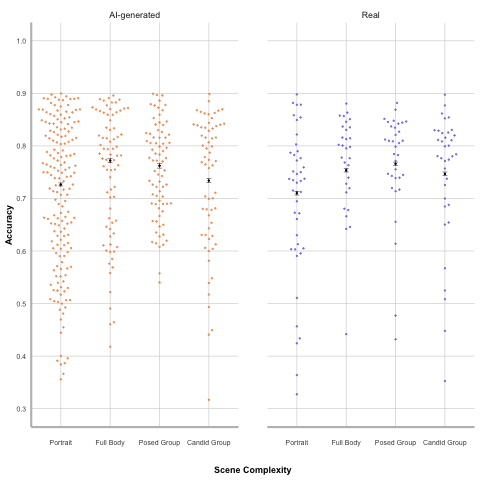

In [28]:
%%R

# Calculate accuracy for each image and filter out images with accuracy > 90%
# Join with observation data to get real/fake labels and subcategories
# Calculate bootstrapped confidence intervals for mean accuracy by image type and subcategory
# Create beeswarm plot showing accuracy distribution with error bars


df_image_accuracy_filtered <- df_image_accuracy %>%
  filter(accuracy <= 0.90)
df_image_accuracy_filtered$real_or_fake <- ifelse(df_image_accuracy_filtered$fake_or_real == "Reals", "Real", "AI-generated")
df_image_accuracy_filtered$subcategory <- gsub("Naturalistic Group", "Candid Group", df_image_accuracy_filtered$subcategory)

# test that df_image_accuracy_filtered has the correct structure and content
test_that("df_image_accuracy_filtered has correct structure and content", {
  expect_true(is.data.frame(df_image_accuracy_filtered))
  expect_true(all(colnames(df_image_accuracy) %in% colnames(df_image_accuracy_filtered)))
  expect_true(all(c("real_or_fake", "subcategory") %in% colnames(df_image_accuracy_filtered)))
})

obs_data <- merged_df %>%
  inner_join(df_image_accuracy_filtered %>% select(filename_old), by = "filename_old") %>%
  mutate(
    real_or_fake = ifelse(category == "Reals", "Real", "AI-generated"),
    subcategory = case_when(
      grepl("_ng_|ng[0-9]", filename_old) ~ "Candid Group",
      grepl("_pg_|pg[0-9]", filename_old) ~ "Posed Group",
      grepl("_fullbody|fullbody[0-9]", filename_old) ~ "Full Body",
      grepl("_portrait|portrait[0-9]", filename_old) ~ "Portrait",
      TRUE ~ NA_character_
    )
  )

# test that obs_data has the correct structure and content
test_that("obs_data has correct structure and content", {
  expect_true(is.data.frame(obs_data))
  expect_true(all(colnames(merged_df) %in% colnames(obs_data)))
  expect_true('subcategory' %in% colnames(obs_data))
  expect_true('real_or_fake' %in% colnames(obs_data))
})

boot_mean <- function(data, indices) {
  mean(data$is_correct[indices])
}

ci_data <- obs_data %>%
  group_by(real_or_fake, subcategory) %>%
  summarise(
    mean = mean(is_correct),
    boot_obj = list(boot(data = cur_data(), statistic = boot_mean, R = 10000)),
    .groups = "drop"
  ) %>%
  rowwise() %>%
  mutate(
    ci = list(boot.ci(boot_obj, type = "perc", conf = 0.95)),
    lower = ci$percent[4],
    upper = ci$percent[5]
  ) %>%
  select(real_or_fake, subcategory, mean, lower, upper)

# test that ci_data has the correct structure and content
test_that("ci_data has correct structure and content", {
  expect_true(is.data.frame(ci_data))
  expect_true(all(c("real_or_fake", "subcategory", "mean", "lower", "upper") %in% colnames(ci_data)))
})

ordered_categories <- c('Candid Group', 'Posed Group', 'Full Body', 'Portrait')
colors_bee <- c("AI-generated" = "#F58C42", "Real" = "#6F6FF0")

df_image_accuracy_filtered$subcategory <- factor(df_image_accuracy_filtered$subcategory, levels = ordered_categories)
ci_data$subcategory <- factor(ci_data$subcategory, levels = ordered_categories)

p <- ggplot(df_image_accuracy_filtered, aes(x = forcats::fct_rev(subcategory), y = accuracy)) +
  geom_beeswarm(aes(color = real_or_fake), alpha = 0.7, size = 0.3, groupOnX = TRUE, cex = 2) +
  geom_point(data = ci_data, aes(y = mean), size = 0.3, color = "black") +
  geom_errorbar(data = ci_data, 
                aes(y = mean, ymin = lower, ymax = upper),
                width = 0.1, size = 0.2, color = "black") +
  scale_color_manual(values = colors_bee, name = "NULL") +
  scale_x_discrete(name = "Scene Complexity") +
  scale_y_continuous(name = "Accuracy", limits = c(0.3, 1), breaks = seq(0.3, 1, 0.1)) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 0, hjust = 0.5, size = 7, margin = margin(t = 10)),
    axis.text.y = element_text(size = 7),
    axis.title.x = element_text(size = 9, margin = margin(t = 20), face = "bold"),
    axis.title.y = element_text(size = 9, face = "bold"),
    # legend.text = element_text(size = 9),
    # legend.title = element_text(size = 9),
    panel.grid.major = element_line(color = "lightgray", size = 0.3),
    panel.grid.minor = element_blank(),
    axis.line = element_line(color = "gray", size = 1),
  legend.position = "none",
    panel.spacing = unit(2, "lines"),
    # strip.text = element_text(size = 7)
  ) +
  facet_wrap(~ real_or_fake, ncol = 2, scales = "free_x")

print(p)
ggsave("scene_complexity_filtered90_obsCI.png", plot = p, width = 7.5, height = 2.75, dpi = 300)

cat("\nSummary of filtered data accuracy:\n")
print(summary(df_image_accuracy_filtered$accuracy))


obs_summary <- obs_data %>%
  group_by(real_or_fake, subcategory) %>%
  summarise(
    mean = mean(is_correct),
    n_observations = n(),
    n_images = n_distinct(filename_old)
  )

#observation-level stats
cat("\nSummary by category (observation-level):\n")
print(obs_summary)


#  count and percentage of data points in each group
cat("\nCount and percentage of data points in each group:\n")
group_summary <- df_image_accuracy_filtered %>% 
  group_by(real_or_fake, subcategory) %>%
  summarise(count = n(), .groups = "drop") %>%
  mutate(percentage = count / sum(count) * 100)
print(group_summary)


cat("\nMean accuracies and confidence intervals for each scene complexity category:\n")
print(ci_data)


total_images <- nrow(df_image_accuracy)
excluded_images <- total_images - nrow(df_image_accuracy_filtered)
excluded_percentage <- (excluded_images / total_images) * 100

cat("\nExclusion criteria statistics:\n")
cat(sprintf("Total images: %d\n", total_images))
cat(sprintf("Excluded images: %d (%.2f%%)\n", excluded_images, excluded_percentage))


exclusion_by_subcategory <- df_image_accuracy %>%
  group_by(subcategory) %>%
  summarise(
    total = n(),
    excluded = sum(accuracy > 0.90),
    excluded_percentage = (excluded / total) * 100,
    .groups = "drop"
  )

cat("\nExclusion by subcategory:\n")
print(exclusion_by_subcategory)

print(levels(forcats::fct_rev(df_image_accuracy_filtered$subcategory)))


### 5.4 Accuracy by Presence of Artifacts
#### Figure 11

Test passed 🎊
# A tibble: 3 × 4
  artifact   mean_accuracy ci_lower ci_upper
  <chr>              <dbl>    <dbl>    <dbl>
1 Anatomical         0.650    0.645    0.654
2 Functional         0.641    0.638    0.645
3 Stylistic          0.649    0.645    0.653
# A tibble: 3 × 2
  artifact   n_images
  <chr>         <int>
1 Anatomical      112
2 Functional      128
3 Stylistic        85
[1] "Number of nearly perfectly photorealistic images for each artifact type:"
# A tibble: 3 × 2
  artifact   n_photorealistic_images
  <chr>                        <int>
1 Anatomical                      28
2 Functional                      46
3 Stylistic                       20
[1] "Proportion of photorealistic images for each artifact type:"
# A tibble: 3 × 4
  artifact   n_photorealistic_images total_images proportion_photorealistic
  <chr>                        <int>        <int>                     <dbl>
1 Anatomical                      28          112                      25  
2 Functional         

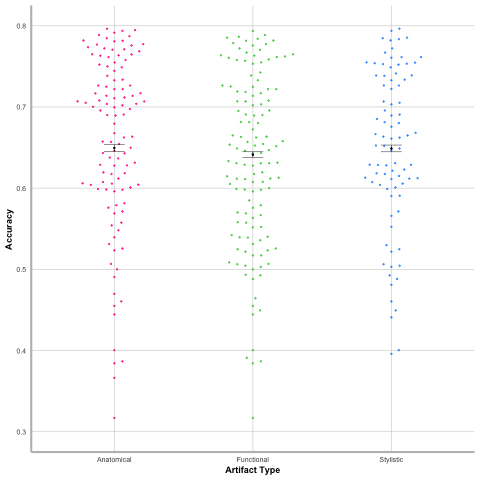

In [30]:
%%R

# This cell analyzes the relationship between image artifacts and detection accuracy
# First, we prepare the data by:
# 1. Converting artifact indicators from categorical to numeric (0/1)
# 2. Calculating total number of artifacts per image
# 3. Merging with accuracy data, filtering out real images
# 4. Creating two datasets:
#    - image_data: For beeswarm visualization of image-level accuracies
#    - obs_data: For calculating confidence intervals from individual observations
# Then we calculate confidence intervals using bootstrapping
# Finally, we create a visualization showing accuracy distribution by artifact type

data <- data_annotations
# Convert artifact columns to numeric
artifact_columns <- c("anatomical", "stylistic", "functional", "law_of_physics", "sociocultural")
data[artifact_columns] <- lapply(data[artifact_columns], function(x) {
  as.numeric(ifelse(x == "1", 1, 0))
})

# Calculate the number of artifacts for each image
data$num_artifacts <- rowSums(data[, artifact_columns])

test_that("data has correct structure and content", {
  expect_true(is.data.frame(data))
  expect_true(all(colnames(data_annotations) %in% colnames(data)))
  expect_true(all(artifact_columns %in% colnames(data)))
  expect_true(all(c("num_artifacts") %in% colnames(data)))
})

merged_data <- data %>%
  left_join(df_image_accuracy, by = "filename") %>%
  filter(fake_or_real.y != "Reals")  # Keep only fake images


# Create image-level data for beeswarm with df_image_accuracy
image_data <- data %>%
  select(filename, anatomical, stylistic, functional, law_of_physics, sociocultural) %>%
  inner_join(df_image_accuracy %>% filter(accuracy <= 0.80), by = "filename") %>%
  pivot_longer(cols = c(anatomical, stylistic, functional),
               names_to = "artifact",
               values_to = "has_artifact") %>%
  filter(has_artifact == 1)
image_data$artifact <- str_to_title(image_data$artifact)


# Create observation-level data for CIs
obs_data <- data %>%
  select(filename, anatomical, stylistic, functional, law_of_physics, sociocultural) %>%
  inner_join(merged_df, by = "filename") %>%
  inner_join(df_image_accuracy %>% filter(accuracy <= 0.80), by = "filename") %>%
  pivot_longer(cols = c(anatomical, stylistic, functional),
               names_to = "artifact",
               values_to = "has_artifact") %>%
  filter(has_artifact == 1)
obs_data$artifact <- str_to_title(obs_data$artifact)

# Calculate CIs from observation data
aggregated_data <- obs_data %>%
  group_by(artifact) %>%
  summarise(
    mean_accuracy = mean(is_correct),
    boot_obj = list(boot(is_correct, function(data, indices) mean(data[indices]), R = 10000)),
    ci_lower = boot.ci(boot_obj[[1]], type = "perc", conf = 0.95)$percent[4],
    ci_upper = boot.ci(boot_obj[[1]], type = "perc", conf = 0.95)$percent[5]
  ) %>%
  select(-boot_obj)


p1 <- ggplot(image_data, aes(x = artifact, y = accuracy, color = artifact)) +
  geom_beeswarm(cex = 2, size = 0.3, alpha = 0.7) +
  geom_point(data = aggregated_data, aes(y = mean_accuracy), size = 0.3, color = "black") +
  geom_errorbar(data = aggregated_data, 
                aes(y = mean_accuracy, ymin = ci_lower, ymax = ci_upper),
                width = 0.15, size = 0.2, color = "black") +
  scale_color_manual(values = c("Anatomical" = "#FF1493",
                               "Stylistic" = "#1E90FF",
                               "Functional" = "#32CD32")) +
  labs(x = "Artifact Type", y = "Accuracy") +
  theme_minimal() +
  scale_y_continuous(limits = c(0.3, 0.8), breaks = seq(0.3, 0.8, 0.1)) +
  theme(
    legend.position = "none",
    axis.text = element_text(size = 7),
    axis.title = element_text(size = 9, face = "bold"),
    panel.grid.major = element_line(color = "lightgray", linewidth = 0.3),
    panel.grid.minor = element_blank(),
    axis.line = element_line(color = "gray", linewidth = 1)
  )

print(p1)
ggsave("accuracy_by_artifact_type_obs_ci.png", p1, width = 3.5, height = 2.75, dpi = 300)

print(aggregated_data)
print(image_data %>% group_by(artifact) %>% summarize(n_images = n_distinct(filename)))

# Calculate the number of nearly perfectly photorealistic images for each artifact
nearly_photorealistic_images <- image_data %>%
  filter(accuracy <= 0.60) %>%  # Filter for accuracy ≤ 50%
  group_by(artifact) %>%
  summarise(
    n_photorealistic_images = n_distinct(filename)  # Count unique filenames for each artifact
  )

# Print the results
print("Number of nearly perfectly photorealistic images for each artifact type:")
print(nearly_photorealistic_images)

# Calculate the proportion of photorealistic images for each artifact type
total_images_per_artifact <- image_data %>%
  group_by(artifact) %>%
  summarise(
    total_images = n_distinct(filename)  # Count total unique images per artifact
  )

proportion_photorealistic <- nearly_photorealistic_images %>%
  left_join(total_images_per_artifact, by = "artifact") %>%
  mutate(
    proportion_photorealistic = n_photorealistic_images / total_images * 100
  )

# Print the proportion of photorealistic images
print("Proportion of photorealistic images for each artifact type:")
print(proportion_photorealistic)

### 5.5 Accuracy by Randomized Display Time

[1] "Summary statistics by display time and image type:"
# A tibble: 10 × 7
   display_time fake_or_real mean_acc     n      se ci_lower ci_upper
   <fct>        <chr>           <dbl> <int>   <dbl>    <dbl>    <dbl>
 1 1s           Fake            0.721 38411 0.00229    0.716    0.725
 2 5s           Fake            0.774 39532 0.00210    0.770    0.778
 3 10s          Fake            0.800 40310 0.00199    0.796    0.804
 4 20s          Fake            0.816 40587 0.00192    0.812    0.819
 5 unlimited    Fake            0.820 41529 0.00189    0.816    0.823
 6 1s           Real            0.718 34895 0.00241    0.713    0.723
 7 5s           Real            0.770 36127 0.00221    0.766    0.775
 8 10s          Real            0.765 36773 0.00221    0.760    0.769
 9 20s          Real            0.764 36911 0.00221    0.760    0.769
10 unlimited    Real            0.769 37647 0.00217    0.764    0.773


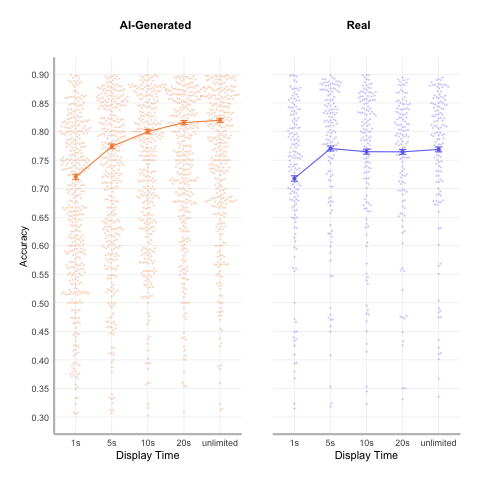

In [32]:
%%R

# Calculate accuracy statistics by display time condition
# Filter out 0.1 second condition and create factor levels for display times
# Prepare data for both image-level and observation-level analysis


filtered_df <- merged_df %>%
  group_by(user_id) %>%
  arrange(user_id, id) %>%
  mutate(obs_order = row_number()) %>%
  filter(obs_order > 5) %>%  # Exclude first 5 observations
  ungroup()


# Image-level accuracy calculation
image_accuracy <- merged_df %>%
  group_by(filename, fake_or_real, assignment) %>%
  summarize(
    accuracy = mean(is_correct, na.rm = TRUE),
    .groups = 'drop'
  ) %>%
  filter(!is.na(assignment), assignment != "0.1 seconds") %>%
  mutate(
    display_time = factor(case_when(
      assignment == "1 second" ~ "1s",
      assignment == "5 seconds" ~ "5s",
      assignment == "10 seconds" ~ "10s",
      assignment == "20 seconds" ~ "20s",
      assignment == "unlimited" ~ "unlimited"
    ), levels = c("1s", "5s", "10s", "20s", "unlimited"))
  )

# Observation-level data prep
accuracy_by_time <- merged_df %>%
  filter(!is.na(is_correct), !is.na(assignment), assignment != "0.1 seconds") %>%
  mutate(
    display_time = factor(case_when(
      assignment == "1 second" ~ "1s",
      assignment == "5 seconds" ~ "5s",
      assignment == "10 seconds" ~ "10s",
      assignment == "20 seconds" ~ "20s",
      assignment == "unlimited" ~ "unlimited"
    ), levels = c("1s", "5s", "10s", "20s", "unlimited"))
  )


# Image-level accuracy calculation
image_accuracy <- filtered_df %>%
  group_by(filename, fake_or_real, assignment) %>%
  summarize(
    accuracy = mean(is_correct, na.rm = TRUE),
    .groups = 'drop'
  ) %>%
  filter(!is.na(assignment), assignment != "0.1 seconds", accuracy < 0.9) %>%  # Filter accuracy < 90%
  mutate(
    display_time = factor(case_when(
      assignment == "1 second" ~ "1s",
      assignment == "5 seconds" ~ "5s",
      assignment == "10 seconds" ~ "10s",
      assignment == "20 seconds" ~ "20s",
      assignment == "unlimited" ~ "unlimited"
    ), levels = c("1s", "5s", "10s", "20s", "unlimited"))
  )

# Observation-level data prep
accuracy_by_time <- filtered_df %>%
  filter(!is.na(is_correct), !is.na(assignment), assignment != "0.1 seconds") %>%
  mutate(
    display_time = factor(case_when(
      assignment == "1 second" ~ "1s",
      assignment == "5 seconds" ~ "5s",
      assignment == "10 seconds" ~ "10s",
      assignment == "20 seconds" ~ "20s",
      assignment == "unlimited" ~ "unlimited"
    ), levels = c("1s", "5s", "10s", "20s", "unlimited"))
  )

# Calculate observation-level summary stats
summary_stats <- accuracy_by_time %>%
  group_by(display_time, fake_or_real) %>%
  summarise(
    mean_acc = mean(is_correct, na.rm = TRUE),
    n = n(),
    se = sqrt((mean_acc * (1 - mean_acc)) / n),
    ci_lower = mean_acc - 1.96 * se,
    ci_upper = mean_acc + 1.96 * se,
    .groups = 'drop'
  ) %>%
  filter(!is.na(display_time))

# Plot creation function
create_time_plot <- function(obs_data, img_data, stats, point_color, show_axis = TRUE) {
  ggplot() +
    # Image-level accuracy beeswarm
    geom_beeswarm(
      data = img_data,
      aes(x = display_time, y = accuracy),
      color = point_color,
      alpha = 0.2,
      size = 0.3,
      cex = 1.2,
      priority = "random"
    ) +
    # Observation-level accuracy beeswarm
    geom_beeswarm(
      data = obs_data,
      aes(x = display_time, y = is_correct),
      color = point_color,
      alpha = 0.1,
      size = 0.2,
      cex = 1.5,
      priority = "random"
    ) +
    geom_errorbar(
      data = stats,
      aes(x = display_time, ymin = ci_lower, ymax = ci_upper),
      width = 0.2,
      color = point_color,
      size = 0.5
    ) +
    geom_point(
      data = stats,
      aes(x = display_time, y = mean_acc),
      size = 1.2,
      color = point_color
    ) +
    geom_line(
      data = stats,
      aes(x = display_time, y = mean_acc, group = 1),
      color = point_color,
      size = 0.5
    ) +
    scale_y_continuous(
      limits = c(0.3, 0.9),
      breaks = seq(0.3, 0.9, 0.05)
    ) +
    labs(
      x = "Display Time",
      y = if (show_axis) "Accuracy" else NULL  # Show y-axis label if show_axis is TRUE
    ) +
    theme_minimal() +
    theme(
      panel.grid.major = element_line(color = "gray90", size = 0.2),
      panel.grid.minor = element_blank(),
      axis.text.x = element_text(angle = 0, size = 9, color = "gray30"),
      axis.text.y = if (show_axis) element_text(size = 9, color = "gray30") else element_blank(),
      axis.title.y = if (show_axis) element_text(size = 10) else element_blank(),
      axis.line.x = element_line(color = "gray", linewidth = 1),  # Always show X-axis line
      axis.line.y = if (show_axis) element_line(color = "gray", linewidth = 1) else element_blank(),  # Conditionally show Y-axis line
      plot.title = element_blank(),  # Remove plot title
      plot.margin = unit(c(0.5, 0.5, 0.5, 0.5), "cm")
    )
}

# Create individual plots
fake_plot <- create_time_plot(
  filter(accuracy_by_time, fake_or_real == "Fake"),
  filter(image_accuracy, fake_or_real == "Fake"),
  filter(summary_stats, fake_or_real == "Fake"),
  "#F58C42",
  show_axis = TRUE  
)

real_plot <- create_time_plot(
  filter(accuracy_by_time, fake_or_real == "Real"),
  filter(image_accuracy, fake_or_real == "Real"),
  filter(summary_stats, fake_or_real == "Real"),
  "#6F6FF0",
  show_axis = FALSE  #
)

# Add labels for AI-Generated and Real
fake_label <- ggplot() + 
  annotate("text", x = 0.5, y = 0.5, label = "AI-Generated", size = 4, fontface = "bold", hjust = 0.5) +
  theme_void()

real_label <- ggplot() + 
  annotate("text", x = 0.5, y = 0.5, label = "Real", size = 4, fontface = "bold", hjust = 0.5) +
  theme_void()

# Combine plots
combined_plot <- (fake_label + real_label) / (fake_plot + real_plot) +
  plot_layout(heights = c(0.1, 1))  # Allocate space for labels

# Save and display the final plot
print(combined_plot)
ggsave("accuracy_by_display_time.png", combined_plot, 
       width = 12, height = 5, dpi = 300)

   
print("Summary statistics by display time and image type:")
print(summary_stats %>% arrange(fake_or_real, display_time))


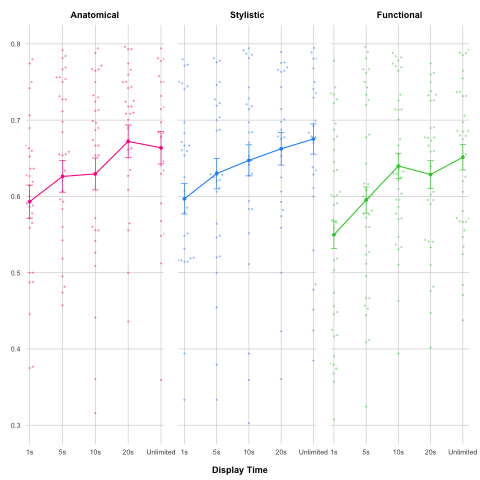

In [33]:
%%R

# This cell analyzes accuracy patterns for AI-generated images with artifacts
# It creates lists of dataframes for each display time condition (1s, 5s, 10s, 20s, unlimited)
# Each dataframe contains accuracy scores and artifact counts per image
# The cell also sets up functions to:
# 1. Calculate accuracy by display time for specific artifact types
# 2. Compute confidence intervals for statistical analysis


df_list <- list()
for (time in c("1 second", "5 seconds", "10 seconds", "20 seconds", "unlimited")) {
  df <- filtered_df %>%
    filter(assignment == time) %>%
    group_by(filename) %>%
    summarize(
      accuracy = mean(is_correct, na.rm = TRUE),
      observations = n(),
      fake = first(fake),
      .groups = 'drop'
    ) %>%
    filter(fake == 1, accuracy <= 0.80) %>%  # Filter for AI-generated and accuracy <= 80%
    inner_join(data %>% select(filename, anatomical, stylistic, functional), by = "filename") %>%
    mutate(num_artifacts = anatomical + stylistic + functional)
  
  df_list[[time]] <- df
}


obs_data <- filtered_df %>%
  filter(!is.na(is_correct), !is.na(assignment)) %>%
  inner_join(data %>% select(filename, anatomical, stylistic, functional), by = "filename") %>%
  pivot_longer(
    cols = c("anatomical", "stylistic", "functional"),
    names_to = "artifact",
    values_to = "has_artifact"
  )


calculate_time_accuracy <- function(df_list, artifact_type) {
  time_assignments <- names(df_list)
  result <- data.frame(time = character(), accuracy = numeric(), filename = character(), stringsAsFactors = FALSE)
  for (time in time_assignments) {
    df_filtered <- df_list[[time]] %>%
      filter(num_artifacts == 1, !!sym(artifact_type) == 1)
    if (nrow(df_filtered) > 0) {
      result <- rbind(result, data.frame(
        time = rep(time, nrow(df_filtered)),
        accuracy = df_filtered$accuracy,
        filename = df_filtered$filename
      ))
    }
  }
  return(result)
}


calculate_ci <- function(time_data, obs_data, artifact_name) {
  ci_data <- obs_data %>%
    inner_join(time_data %>% select(filename, time), by = c("filename", "assignment" = "time")) %>%
    filter(has_artifact == 1 & artifact == artifact_name) %>%
    group_by(assignment) %>%
    summarise(
      n = n(),
      mean_acc = mean(is_correct, na.rm = TRUE),
      se = sqrt((mean_acc * (1 - mean_acc)) / n),
      lower = mean_acc - 1.96 * se,
      upper = mean_acc + 1.96 * se,
      .groups = 'drop'
    ) %>%
    rename(time = assignment)
  return(ci_data)
}


adjust_time_levels <- function(ci_data) {
  ci_data <- ci_data %>%
    mutate(time = factor(time, levels = c("1 second", "5 seconds", "10 seconds", "20 seconds", "unlimited"))) %>%
    arrange(time)
  return(ci_data)
}

adjust_time_data_levels <- function(time_data) {
  time_data <- time_data %>%
    mutate(time = factor(time, levels = c("1 second", "5 seconds", "10 seconds", "20 seconds", "unlimited"))) %>%
    arrange(time)
  return(time_data)
}


anatomical_time_data <- calculate_time_accuracy(df_list, "anatomical")
stylistic_time_data <- calculate_time_accuracy(df_list, "stylistic")
functional_time_data <- calculate_time_accuracy(df_list, "functional")

anatomical_ci <- calculate_ci(anatomical_time_data, obs_data, "anatomical")
stylistic_ci <- calculate_ci(stylistic_time_data, obs_data, "stylistic")
functional_ci <- calculate_ci(functional_time_data, obs_data, "functional")

anatomical_ci <- adjust_time_levels(anatomical_ci)
stylistic_ci <- adjust_time_levels(stylistic_ci)
functional_ci <- adjust_time_levels(functional_ci)

anatomical_time_data <- adjust_time_data_levels(anatomical_time_data)
stylistic_time_data <- adjust_time_data_levels(stylistic_time_data)
functional_time_data <- adjust_time_data_levels(functional_time_data)


plot_artifact_accuracy <- function(time_data, ci_data, artifact_name, color, show_y_axis = TRUE) {
  ggplot() +
    geom_beeswarm(data = time_data, aes(x = time, y = accuracy),
                  size = 0.3, alpha = 0.3, color = color, cex = 2) +
    geom_point(data = ci_data, aes(x = time, y = mean_acc),
               size = 1, color = color) +
    geom_line(data = ci_data, aes(x = time, y = mean_acc, group = 1),
              size = 0.5, color = color) +
    geom_errorbar(data = ci_data,
                  aes(x = time, y = mean_acc, ymin = lower, ymax = upper),
                  width = 0.2, size = 0.3, color = color) +
    labs(title = artifact_name) +
    theme_minimal() +
    theme(
      axis.text.x = element_text(size = 7, color = "gray30"),
      axis.text.y = if (show_y_axis) element_text(size = 7, color = "gray30") else element_blank(),
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      plot.title = element_text(size = 9, face = "bold", hjust = 0.5),
      panel.grid.major = element_line(color = "lightgray", linewidth = 0.3),
      panel.grid.minor = element_blank()
    ) +
    scale_y_continuous(limits = c(0.3, 0.8), breaks = seq(0.3, 0.8, by = 0.1)) +
    scale_x_discrete(labels = c("1s", "5s", "10s", "20s", "Unlimited"), expand = c(0, 0))
}

# Create plots
plot_anatomical <- plot_artifact_accuracy(anatomical_time_data, anatomical_ci, "Anatomical", "#FF1493", show_y_axis = TRUE)
plot_stylistic <- plot_artifact_accuracy(stylistic_time_data, stylistic_ci, "Stylistic", "#1E90FF", show_y_axis = FALSE)
plot_functional <- plot_artifact_accuracy(functional_time_data, functional_ci, "Functional", "#32CD32", show_y_axis = FALSE)

combined_plot <- (plot_anatomical + plot_stylistic + plot_functional) +
  plot_layout(ncol = 3) +
  plot_annotation(
    caption = "Display Time",
    theme = theme(
      plot.caption = element_text(size = 9, face = "bold", hjust = 0.5, margin = margin(t = 5))
    )
  )


print(combined_plot)
ggsave("artifact_accuracy_time.png", plot = combined_plot, width = 7.5, height = 2.75, dpi = 300)


### Qualitative Analysis of Participant Comments
#### Figure 14

# A tibble: 10 × 4
   theme     n theme_description                                      percentage
   <dbl> <int> <chr>                                                       <dbl>
 1     6  7784 Image Quality (Stylistic)                                  19.2  
 2     3  6472 Anatomical and Functional Anomalies (Anatomical)           16.0  
 3     2  5613 Biometric Discrepancies (Anatomical)                       13.9  
 4     4  4360 Lighting and Environmental Inconsistencies (Physics)       10.8  
 5     5  4338 Digital Manipulation Indicators (Vague)                    10.7  
 6     1  3613 Facial and Anatomical Inconsistencies (Anatomical)          8.93 
 7     9  3223 Contextual Incongruities (Functional or Sociocultural)      7.97 
 8     7  2371 Uncanny Valley Perceptions (Stylistic)                      5.86 
 9     8  2369 Physical Anomalies (Anatomical)                             5.86 
10    10   305 Holistic Authenticity Assessment (Vague)                    0.754


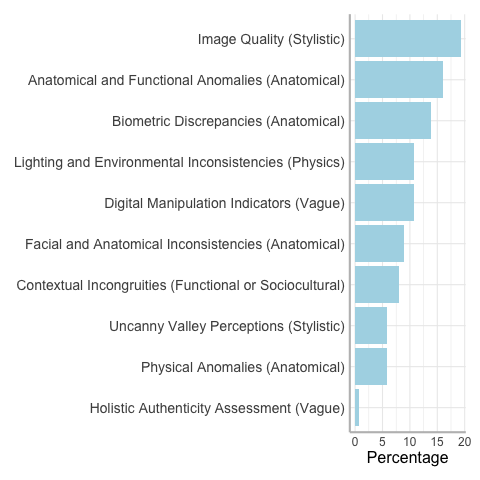

In [35]:
%%R

# Load and process participant comments data
# This cell analyzes the frequency of different themes identified in participant comments
# about how they detected AI-generated images. The themes are pre-defined categories
# covering anatomical, stylistic, functional and other aspects that participants noticed.
# The results are visualized as a horizontal bar chart showing the percentage of comments
# falling into each theme category.


df1 <- df_comments

themes <- c(
  "Facial and Anatomical Inconsistencies (Anatomical)",
  "Biometric Discrepancies (Anatomical)",
  "Anatomical and Functional Anomalies (Anatomical)",
  "Lighting and Environmental Inconsistencies (Physics)",
  "Digital Manipulation Indicators (Vague)",
  "Image Quality (Stylistic)",
  "Uncanny Valley Perceptions (Stylistic)",
  "Physical Anomalies (Anatomical)",
  "Contextual Incongruities (Functional or Sociocultural)",
  "Holistic Authenticity Assessment (Vague)"
)


theme_counts <- df1 %>%
  mutate(classification = strsplit(classification, ",")) %>%
  unnest(classification) %>%
  mutate(classification = as.numeric(classification)) %>%
  filter(!is.na(classification) & classification > 0 & classification <= length(themes)) %>%
  count(classification) %>%
  rename(theme = classification) %>%
  mutate(
    theme_description = themes[theme],
    percentage = (n / sum(n)) * 100  # Calculate percentage
  ) %>%
  arrange(desc(percentage))


p <- ggplot(theme_counts, aes(x = percentage, y = reorder(theme_description, percentage))) +
  geom_bar(stat = "identity", fill = "lightblue") +
  theme_minimal() +
  theme(
    axis.text.y = element_text(size = 14),  # Smaller y-axis ticks
    axis.text.x = element_text(size = 12),  # Smaller x-axis ticks
    axis.title.x = element_text(size = 16), # Smaller x-axis title
    axis.title.y = element_blank(),       # No y-axis title
    plot.title = element_text(size = 11, face = "bold", hjust = 0.5),  # Smaller title
    plot.margin = margin(0.5, 0.5, 0.5, 0.5, "cm"),
axis.line.x = element_line(color = "gray", size = 1),
axis.line.y = element_line(color = "gray", size = 1)
  ) +
  labs(
    
    x = "Percentage",
    y = NULL
  )


print(p)


ggsave("theme_distribution_single_column.png", p, width = 10, height = 6, dpi = 300)


print(theme_counts)


### 5.7 Accuracy by Models


Bootstrap CI for observation-level accuracy:
# A tibble: 3 × 4
# Rowwise: 
  model             mean lower upper
  <fct>            <dbl> <dbl> <dbl>
1 Firefly          0.730 0.727 0.733
2 MidJourney       0.755 0.752 0.758
3 Stable Diffusion 0.743 0.739 0.748


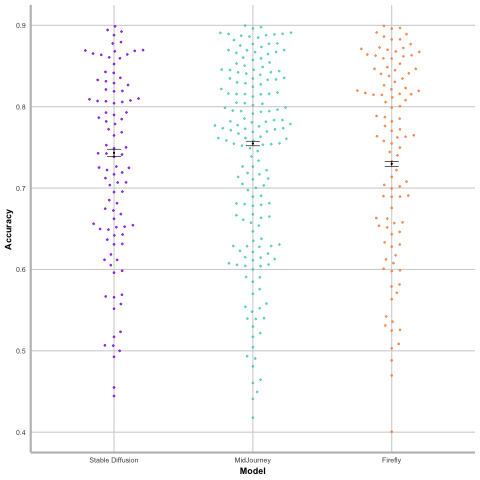

In [37]:
%%R

# Calculate accuracy by model
# Group data by model and compute mean accuracy with bootstrapped confidence intervals
# Use boot package for bootstrapping with 10000 replicates
# Filter for accuracy <= 0.90 to focus on more challenging cases
# Join with observation-level data to get individual classifications
# Calculate confidence intervals using percentile method


# Filter  for images with accuracy <= 0.90
df_image_accuracy_filtered <- df_image_accuracy %>%
  dplyr::filter(accuracy <= 0.90) %>%
  mutate(
    real_or_fake = ifelse(fake_or_real == "Reals", "Real", "AI-generated"),
    subcategory = case_when(
      grepl("_ng_|ng[0-9]", filename_old) ~ "Candid Group",
      grepl("_pg_|pg[0-9]", filename_old) ~ "Posed Group",
      grepl("_fullbody|fullbody[0-9]", filename_old) ~ "Full Body",
      grepl("_portrait|portrait[0-9]", filename_old) ~ "Portrait",
      TRUE ~ NA_character_
    ),
    model = case_when(
      grepl("^mj_", filename_old) ~ "MidJourney",
      grepl("^ff_", filename_old) ~ "Firefly",
      grepl("^sd_", filename_old) ~ "Stable Diffusion",
      TRUE ~ NA_character_
    )
  ) %>%
  dplyr::filter(!is.na(model))  # Exclude rows with missing model information

#  observation-level data
obs_data <- merged_df %>%
  inner_join(df_image_accuracy_filtered %>% select(filename_old), by = "filename_old") %>%
  mutate(model = case_when(
    grepl("^mj_", filename_old) ~ "MidJourney",
    grepl("^ff_", filename_old) ~ "Firefly",
    grepl("^sd_", filename_old) ~ "Stable Diffusion",
    TRUE ~ NA_character_
  )) %>%
  dplyr::filter(!is.na(model))  # Exclude rows with missing model information

    
boot_mean <- function(data, indices) {
  mean(data$is_correct[indices], na.rm = TRUE)
}

#  observation-level means and bootstrapped CIs
ci_data <- obs_data %>%
  group_by(model) %>%
  summarise(
    mean = mean(is_correct, na.rm = TRUE),
    boot_result = list(boot(data = cur_data(), statistic = boot_mean, R = 10000)),
    .groups = "drop"
  ) %>%
  rowwise() %>%
  mutate(
    ci = list(boot.ci(boot_result, type = "perc")$percent[4:5]),
    lower = ci[1],
    upper = ci[2]
  ) %>%
  select(model, mean, lower, upper)


ordered_models <- c("Stable Diffusion", "MidJourney", "Firefly")
colors_bee <- c("Firefly" = "#F58C42", "MidJourney" = "#4ECDC4", "Stable Diffusion" = "#8A2BE2")


df_image_accuracy_filtered$model <- factor(df_image_accuracy_filtered$model, levels = ordered_models)
ci_data$model <- factor(ci_data$model, levels = ordered_models)

    
p <- ggplot(df_image_accuracy_filtered, aes(x = model, y = accuracy, color = model)) +
  geom_beeswarm(dodge.width = 0.8, cex = 2, alpha = 0.7, size = 0.5) +  # Image-level accuracy
  geom_errorbar(data = ci_data,
                aes(y = mean, ymin = lower, ymax = upper),
                width = 0.1, color = "black", size = 0.3) +  # Observation-level CIs
  geom_point(data = ci_data, aes(y = mean), size = 0.2, color = "black") +  # Observation-level mean
  scale_color_manual(values = colors_bee) +
  labs(x = "Model", y = "Accuracy") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 0, hjust = 0.5, size = 7),
    axis.text.y = element_text(size = 7),
    axis.title = element_text(size = 9, face = "bold"),
    axis.title.x = element_text(face = "bold"),
    axis.title.y = element_text(face = "bold"),
    panel.grid.minor = element_blank(),
    panel.grid.major = element_line(color = "lightgray"),
    axis.line = element_line(color = "gray", size = 1),
    legend.position = "none",
    plot.margin = margin(5, 5, 5, 5)
  ) +
  scale_x_discrete(limits = ordered_models) +
  scale_y_continuous(limits = c(0.4, 0.9), breaks = seq(0.4, 0.9, 0.1))

   
ggsave("model_accuracy_combined.png", p, width = 3.5, height = 2.75, dpi = 300)
print(p)


cat("\nBootstrap CI for observation-level accuracy:\n")
print(ci_data)


### 5.8 Accuracy on Human Curated Images vs. Uncurated Images

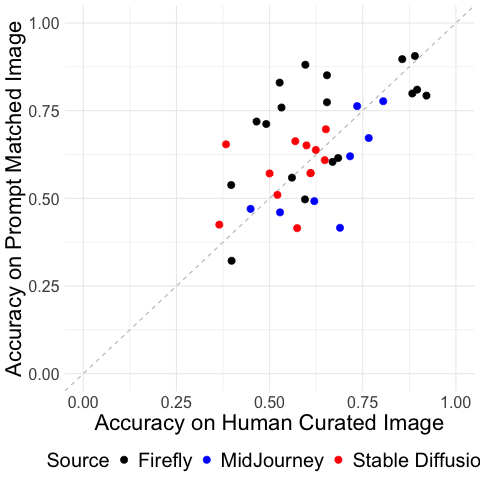

In [39]:
%%R

# Calculate accuracy for each model on human curated images vs. uncurated images
# Create a scatter plot comparing accuracy on human curated images (x-axis) 
# vs accuracy on uncurated/permuted images (y-axis)
# Points below diagonal line indicate that model performs worse on uncurated images
# Points above diagonal line would indicate better performance on uncurated images (unexpected)



df <- df_value_added
p <- ggplot(df, aes(x = `Accuracy.on.Original`, y = `Min.Accuracy..Permuted.`, color = Source)) +

  geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "gray") +

  geom_point(size = 3) +

  scale_color_manual(values = c("Firefly" = "Black", "Stable Diffusion" = "Red", "MidJourney" = "Blue")) +

  labs(x = "Accuracy on Human Curated Image",
       y = "Accuracy on Prompt Matched Image",
       color = "Source") +

  coord_cartesian(xlim = c(0, 1), ylim = c(0, 1)) +

  theme_minimal() +

  theme(
    legend.position = "bottom",
    axis.title = element_text(size = 22, face = "plain"),  # Set axis title size to 26 and not bold
    axis.text = element_text(size = 16),  # Set axis text size to 26
    legend.title = element_text(size = 20, face = "plain"),  # Set legend title size to 22 and not bold
    legend.text = element_text(size = 20)  # Set legend text size to 22
  )


print(p)


ggsave("curation_value_add_min.png", plot = p, width = 8, height = 6, dpi = 300)

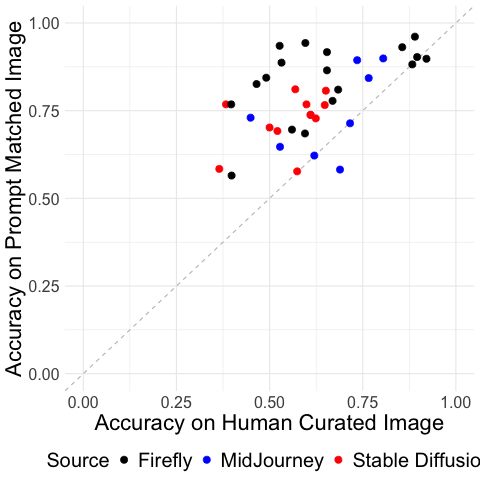

In [40]:
%%R

# Calculate accuracy for each model on human curated images vs. uncurated images
# Create a scatter plot comparing accuracy on human curated images (x-axis) 
# vs mean accuracy on uncurated/permuted images (y-axis)
# Points below diagonal line indicate that model performs worse on uncurated images
# Points above diagonal line would indicate better performance on uncurated images (unexpected)


p <- ggplot(df, aes(x = Accuracy.on.Original, y = Mean.Accuracy..Permuted., color = Source)) +

  geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "gray") +

  geom_point(size = 3) +

  scale_color_manual(values = c("Firefly" = "Black", "Stable Diffusion" = "Red", "MidJourney" = "Blue")) +

  labs(x = "Accuracy on Human Curated Image",
       y = "Accuracy on Prompt Matched Image",
       color = "Source") +

  coord_cartesian(xlim = c(0, 1), ylim = c(0, 1)) +

  theme_minimal() +

  theme(
    legend.position = "bottom",
    axis.title = element_text(size = 22, face = "plain"),  # Set axis title size to 26 and not bold
    axis.text = element_text(size = 16),  # Set axis text size to 26
    legend.title = element_text(size = 20, face = "plain"),  # Set legend title size to 22 and not bold
    legend.text = element_text(size = 20)  # Set legend text size to 22
)

print(p)


ggsave("curation_value_add_mean.png", plot = p, width = 8, height = 6, dpi = 300)